We consider two-dimensional problem of finding the fixed point of contraction mapping defined on a matrix space.

The key assumption is that the fixed point has low-rank structure. 

Thus, instead of search over the full- rank matrix linear space, we use the framework of Riemannian optimization over the manifold of matrices with rank not higher than $r$.

In [43]:
#import
import tt
import numpy as np
import scipy.linalg as la
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
import math

#Graphics
import matplotlib.pyplot as plt
#import prettyplotlib as ppl
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
import matplotlib as mpl
rc_cmufonts = {"font.family": "normal", 
                "font.serif": [], 
                "font.sans-serif": [], 
                "font.monospace": []}

fs = 12
font = {'size' : fs}
mpl.rc('font', **font)
mpl.rcParams.update(rc_cmufonts)
mpl.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'svg'

We seek the fixed point of contraction mapping $\Phi : \mathbb{R}_{n \times m} \to \mathbb{R}_{n \times m}:$ with parameter $\delta$:

$$ \Vert \Phi(X) - \Phi(Y) \Vert \leq \delta \Vert X - Y \Vert, \Phi(X_*) = X_* .$$

Consider a certain converging iterative process
$X_{k+1} = \Phi(X_{k}), k = 0,...$ 

Then, $X_k$ converges linearly to $X_∗$, for $k \to \infty$, i.e. $\Vert X_{k+1} − X_∗\Vert \leq \delta\Vert X_k − X_∗\Vert$.

We assume that initial approximation and fixed point lie on the low rank manifold:
$rank X_0 \leq r, rank X_∗ \leq r$.

Then we create the projected version as 
$$Y_{k+1} = I(Y_k, \Phi(Y_k)−Y_k), k=0,... ,$$
$$Y_0 = X_0.$$
where I(Z, H) is the projector-splitting integrator which is known to be a retraction to the manifold.

In [23]:
#2d case functions
def grad(A, x, x0):
    #u, s, v = x
    #u0, s0, v0 = x0
    #u_new = np.linalg.qr(np.hstack((u, u0)))[0]
    #v_new = np.linalg.qr(np.hstack((v, v0)))[0]
    #s_new = u_new.T.dot(u).dot(s).dot(v.T.dot(v_new)) - u_new.T.dot(u0).dot(s0).dot(v0.T.dot(v_new))
    return x0 - A.dot(full(x).flatten()).reshape(x0.shape)
    #return (u_new, s_new, v_new)


#it is Frobenius norm
def get_norm(x):
    u, s, v = x
    return la.norm(s)
    #return math.sqrt(np.trace((u.T.dot(u)).T.dot(v.T.dot(v))))
    
    
def check_orthogonality(u): 
    if la.norm(u.T.dot(u) - np.eye(u.shape[1])) / math.sqrt(u.shape[1]) < 1e-12:
        return True
    else:
        return False
    
    
def orthogonalize(x):
    u, s, v = x
    u_new, ru = np.linalg.qr(u)
    v_new, lv = np.linalg.qr(u)
    s_new = ru.dot(s.dot(lv))
    return (u_new, s_new, v_new)


def diagonalize_core(x):
    u, s, v = x
    ls, s_diag, rs = la.svd(s)
    return (u.dot(ls), np.diag(s_diag), v.dot(rs))
    

def func(x, x0):
    return get_norm(grad(x, x0))

    
def full(dx):
    return dx[0].dot(dx[1].dot(dx[2].T))


def projector_splitting_2d(x, dx, flag_dual=False):
    n, r = x[0].shape
    u, s, v = x[0].copy(), x[1].copy(), x[2].copy()
    if not flag_dual:
        u, s = np.linalg.qr(u.dot(s) + dx.dot(v))
        s = s - u.T.dot(dx).dot(v)
        v, s = np.linalg.qr(v.dot(s.T) + dx.T.dot(u))
        s = s.T
    else:
        v, s = np.linalg.qr(v.dot(s.T) + dx.T.dot(u))
        s = s.T
        s = s - u.T.dot(dx).dot(v)
        u, s = np.linalg.qr(u.dot(s) + dx.dot(v))
        
    return u, s, v


def inter_point(x, dx):
    u, s, v = x
    u, s = np.linalg.qr(u.dot(s) + dx.dot(v))
    #dx - (I - uu') dx (I - vv') = uu' dx + dx * vv' - uu' dx vv'
    dx_tangent = u.dot(u.T.dot(dx)) + (dx.dot(v)).dot(v.T) - u.dot(u.T.dot(dx).dot(v)).dot(v.T)
    
    return u.copy(), v.copy(), dx_tangent


def minus(x1, x2):
    u1, s1, v1 = x1
    u2, s2, v2 = x2
    u_new = np.linalg.qr(np.hstack((u1, u2)))[0]
    v_new = np.linalg.qr(np.hstack((v1, v2)))[0]
    s_new = u_new.T.dot(u1).dot(s1).dot(v1.T.dot(v_new)) - u_new.T.dot(u2).dot(s2).dot(v2.T.dot(v_new))
    return u_new, s_new, v_new


def ps_proj(x, dx):
    return full(projector_splitting_2d(x, dx)) - full(x)

def rotation(u):
    return la.qr(u)[0]

Consider a linear case, when $\Phi$ is also a linear operator. For the purposes of simplicity we take $m = n$.

So $\Phi$ can be represented as  
$$\Phi (X) = X + A(X) - f,$$

where $A$ is an linear operator on matrix space, $\Vert A - I\Vert = \delta$, 

$f$ is known right-hand side and $X_*$ is the solution of linear equation $A(X_*) = f$.

This problem is equivalent to the minimization problem of the quadratic functional $F(X) = <A(X) - f, X>.$


In [61]:
n, r, r0 = 40, 7, 7

M = n * n 
Q = np.random.randn(M, M)
Q = Q + Q.T
Q = (Q/np.linalg.norm(Q, 2)) * 0.8 # contraction coefficient
A = np.eye(M) + Q

1) Usual case

The singular values of fixed point matrix are 
[ 241.54862237  152.31399683  137.95871557   65.62670563   27.14235118
   22.51935204    2.62057333]


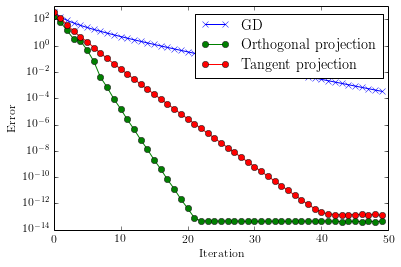

In [63]:
# Case 1: Projector-Splitting versus Descenting Gradient

#Random initialization
x_orig = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start, x_orig = orthogonalize(x_start), orthogonalize(x_orig)
x_orig = diagonalize_core(x_orig)

print 'The singular values of fixed point matrix are \n', np.diag(x_orig[1])

f = full(x_orig)
f = A.dot(f.flatten()).reshape(f.shape)

grad_dist, orth_proj_norm, tangent_proj_norm = [], [], []

        
k = 50

# Gradient Descent Convergence
x = full(x_start)
for i in xrange(k):
    grad_dist.append(la.norm(x - full(x_orig)))
    dx = f - (A.dot(x.flatten())).reshape(x.shape)
    x = x + dx
    
# Projector Splitting Convergence
x = x_start
dx_orig = full(x)-full(x_orig)
for i in xrange(k):
    dx = grad(A, x, f)
    u1, v, dx_tangent = inter_point(x, dx_orig)
    
    dx_orig = full(x)-full(x_orig)
    dx_orig_tangent = u1.dot(u1.T.dot(dx_orig)) + (dx_orig.dot(v)).dot(v.T) - u1.dot(u1.T.dot(dx_orig).dot(v)).dot(v.T)
    
    orth_proj_norm.append(la.norm(dx_orig - dx_orig_tangent))
    tangent_proj_norm.append(la.norm(dx_orig_tangent))
    
    x = projector_splitting_2d(x, dx)
    
# Plotting
plt.semilogy(grad_dist, marker='x', label="GD")
plt.semilogy(orth_proj_norm, marker='o', label="Orthogonal projection")
plt.semilogy(tangent_proj_norm, marker='o', label="Tangent projection")
plt.legend(bbox_to_anchor=(0.40, 1), loc=2)#(1.05, 1), loc=2
plt.xlabel('Iteration')
plt.ylabel('Error')

2) Stair convergence case

The singular values of fixed point matrix are 
[100, 1, 0.01, 0.0001, 1e-06, 1e-08, 1e-10]


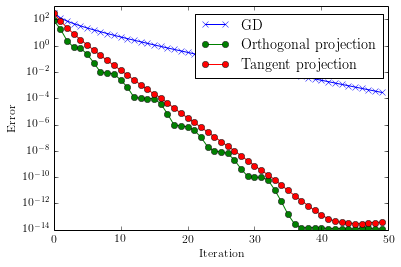

In [64]:
# Case 2: Stair convergence
x_orig = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start, x_orig = orthogonalize(x_start), orthogonalize(x_orig)
x_orig = diagonalize_core(x_orig)
u, s, v = x_orig
s_diag = [10**(2-2*i) for i in xrange(r)]
x_orig = (u, np.diag(s_diag), v)

print 'The singular values of fixed point matrix are \n', s_diag

f = full(x_orig)
f = A.dot(f.flatten()).reshape(f.shape)

grad_dist, orth_proj_norm, tangent_proj_norm = [], [], []

        
k = 50

# Gradient Descent Convergence
x = full(x_start)
for i in xrange(k):
    grad_dist.append(la.norm(x - full(x_orig)))
    dx = f - (A.dot(x.flatten())).reshape(x.shape)
    x = x + dx
    
# Projector Splitting Convergence
x = x_start

for i in xrange(k):
    dx = grad(A, x, f)
    u1, v, dx_tangent = inter_point(x, dx_orig)
    
    dx_orig = full(x)-full(x_orig)
    dx_orig_tangent = u1.dot(u1.T.dot(dx_orig)) + (dx_orig.dot(v)).dot(v.T) - u1.dot(u1.T.dot(dx_orig).dot(v)).dot(v.T)
    
    orth_proj_norm.append(la.norm(dx_orig - dx_orig_tangent))
    tangent_proj_norm.append(la.norm(dx_orig_tangent))
    
    x = projector_splitting_2d(x, dx)
    
# Plotting
plt.semilogy(grad_dist, marker='x', label="GD")
plt.semilogy(orth_proj_norm, marker='o', label="Orthogonal projection")
plt.semilogy(tangent_proj_norm, marker='o', label="Tangent projection")
plt.legend(bbox_to_anchor=(0.40, 1), loc=2)#(1.05, 1), loc=2
plt.xlabel('Iteration')
plt.ylabel('Error')

3) This case shows that projector splitting doesn't always choose the best way.

The singular values of fixed point matrix are 
[100, 1, 0.01, 0.0001, 1e-06, 1e-08, 1e-10]


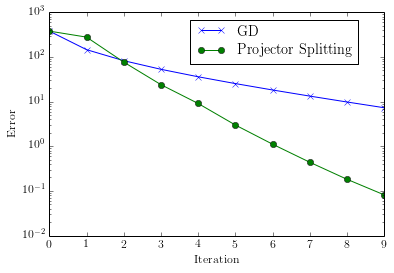

In [65]:
# Case 3: Stair convergence

x_orig = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start = np.random.randn(n, r0), np.random.randn(r0, r0), np.random.randn(n, r0)
x_start, x_orig = orthogonalize(x_start), orthogonalize(x_orig)

eps = 1e-12
u, s, v = x_orig
u1, s1, v1 = x_start
u1 = u1 - u.dot(u.T.dot(u1)) 
v1 = v1 - v.dot(v.T.dot(v1))
x_start = u1, s1, v1

x_orig = diagonalize_core(x_orig)

print 'The singular values of fixed point matrix are \n', s_diag

f = full(x_orig)
f = A.dot(f.flatten()).reshape(f.shape)

grad_dist, proj_dist = [], []

        
k = 10

# Gradient Descent Convergence
x = full(x_start)
for i in xrange(k):
    grad_dist.append(la.norm(x - full(x_orig)))
    dx = f - (A.dot(x.flatten())).reshape(x.shape)
    x = x + dx
    
# Projector Splitting Convergence
x = x_start

for i in xrange(k):
    dx = grad(A, x, f)
    u1, v, dx_tangent = inter_point(x, dx_orig)
    
    dx_orig = full(x)-full(x_orig)    
    proj_dist.append(la.norm(dx_orig))
    
    x = projector_splitting_2d(x, dx)
    
# Plotting
plt.semilogy(grad_dist, marker='x', label="GD")
plt.semilogy(proj_dist, marker='o', label="Projector Splitting")
plt.legend(bbox_to_anchor=(0.40, 1), loc=2)#(1.05, 1), loc=2
plt.xlabel('Iteration')
plt.ylabel('Error')

We know that projector splitting method can fail at 2D case with nonlinear contraction mapping and very small sizes: $n = 2, r = 1$:

$$\Phi(X) = X_* + \delta * \Vert X - X_*\Vert* \begin{pmatrix}
0 & 0 \\
0 & 1 \\
\end{pmatrix},$$

where $X_* = \begin{pmatrix}
1 & 0 \\
0 & 0 \\
\end{pmatrix}, 0 < \delta < 1.$